In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=f3d4eb4beca4d21aaf6961d5697e704c68310ef1fd0bc80c8e7869e07c004ca4
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import yfinance as yf
import pandas as pd
import ta

In [ ]:
#get stock data
ticker = "TLKMF"
data = yf.download(ticker, start="2015-01-01", end="2024-08-10")

#Calculate technical indicators using ta library
def calculate_indicators(df):
  df['SMA_20'] = ta.trend.sma_indicator(df['Close'], window=20)
  df['EMA_20'] = ta.trend.ema_indicator(df['Close'], window=20)
  df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
  df['MACD'] = ta.trend.macd_diff(df['Close'])
  return df


data = calculate_indicators(data)
data = data.dropna()
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,SMA_20,EMA_20,RSI,MACD
Date,,,,,,,,,,
2015-02-20,0.22,0.22,0.22,0.22,0.163298,0,0.2125,0.213928,64.465157,0.001426
2015-02-23,0.22,0.22,0.22,0.22,0.163298,0,0.2120,0.214507,64.465157,0.001484
2015-02-24,0.22,0.22,0.22,0.22,0.163298,229300,0.2125,0.215030,64.465157,0.001450
2015-02-25,0.22,0.22,0.22,0.22,0.163298,0,0.2130,0.215503,64.465157,0.001356
2015-02-26,0.22,0.22,0.22,0.22,0.163298,64000,0.2135,0.215931,64.465157,0.001227
...,...,...,...,...,...,...,...,...,...,...
2024-08-05,0.17,0.17,0.17,0.17,0.170000,0,0.1875,0.186202,31.033848,-0.002964
2024-08-06,0.17,0.17,0.17,0.17,0.170000,0,0.1870,0.184659,31.033848,-0.003322
2024-08-07,0.17,0.17,0.17,0.17,0.170000,0,0.1865,0.183263,31.033848,-0.003386


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Prepare data LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close', 'SMA_20', 'EMA_20', 'RSI', 'MACD']])

#Function to create input sequences
def create_sequences(data, seq_length):
  X, y = [], []
  for i in range(len(data) - seq_length):
    X.append(data[i:(i + seq_length), :])
    y.append(data[i + seq_length, 0])
  return np.array(X), np.array(y)

seq_length = 1

X, y = create_sequences(scaled_data, seq_length)
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

def build_optimized_model(features):
  model = Sequential()
  model.add(LSTM(512, input_shape=(seq_length, features), return_sequences=True))
  model.add(Dropout(0.1))
  model.add(LSTM(512, return_sequences=False))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='linear'))
  optimizer = Adam()
  model.compile(loss='mse', optimizer=optimizer)
  model.summary()
  return model

model = build_optimized_model(features=5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 512)              │       1,060,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 512)                 │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,192,961 (12.18 MB)

 Trainable params: 3,192,961 (12.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=200, batch_size=256, verbose=0)

test_predictions = model.predict(X_test)

# Inverse transform predictions
test_predictions = scaler.inverse_transform(np.concatenate((test_predictions,
                                                             np.zeros((len (test_predictions), 4))),
                                                             axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate ((y_test.reshape(-1, 1),
                                                       np.zeros((len(y_test), 4))),
                                                      axis=1))[:, 0]
# Get dates for the test set
test_dates = data.index [-len(y_test):]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


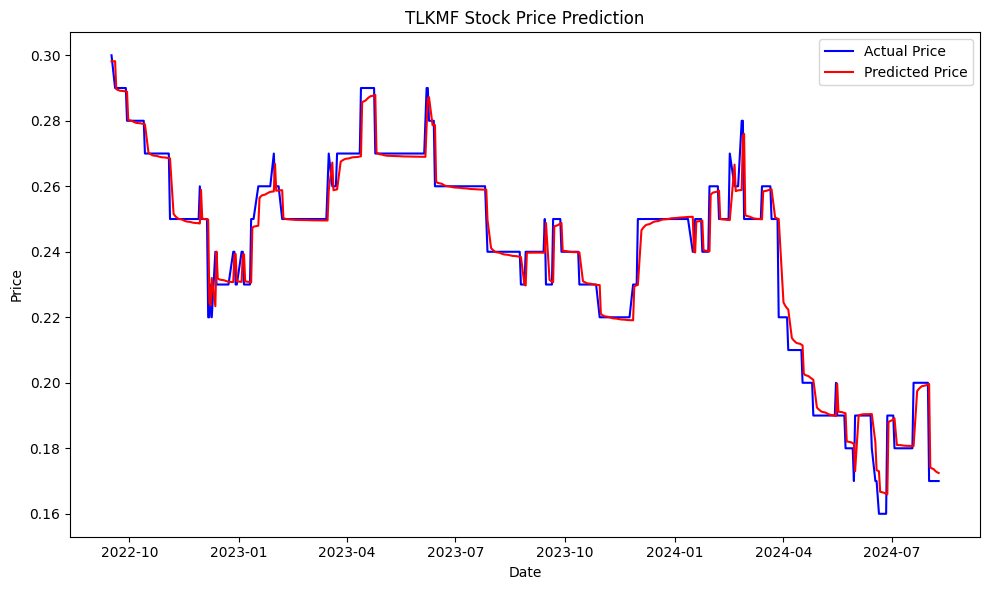

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_dates, y_test_inv, label='Actual Price', color='blue')
plt.plot(test_dates, test_predictions, label='Predicted Price', color='red')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_inv, test_predictions)
mae = mean_absolute_error(y_test_inv, test_predictions)
print(f"Mean Squared Error: {mse:.10f}")
print (f"Mean Absolute Error: {mae:.10f}")

Mean Squared Error: 0.0000313031
Mean Absolute Error: 0.0027799620


In [ ]:
# Save the trained model
model.save('stock_price_prediction_model.h5')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from datetime import timedelta

# Load the saved model with custom loss function
loaded_model = load_model('stock_price_prediction_model.h5', custom_objects={'mse': MeanSquaredError()})

# Function to predict the next n days prices and corresponding dates
def predict_next_days(model, latest_data, scaler, seq_length, days=5, last_date=None):
    predicted_prices = []
    predicted_dates = []

    for i in range(days):
        # Scale the latest data
        scaled_latest_data = scaler.transform(latest_data)

        # Create input sequence for prediction
        X_latest = np.array([scaled_latest_data])

        # Predict the next day price
        predicted_price_scaled = model.predict(X_latest)

        # Inverse transform the predicted price
        predicted_price = scaler.inverse_transform(np.concatenate((predicted_price_scaled, np.zeros((1, 4))), axis=1))[:, 0][0]

        # Append the predicted price to the list
        predicted_prices.append(predicted_price)

        # Update the latest_data with the predicted price for the next prediction
        new_data = np.concatenate(([[predicted_price]], latest_data.values[:, 1:]), axis=1)
        latest_data = pd.DataFrame(new_data, columns=latest_data.columns)

        # Calculate the date for the prediction
        if last_date is not None:
            next_date = last_date + timedelta(days=i + 1)
            predicted_dates.append(next_date)

    return predicted_prices, predicted_dates

# Prepare the latest data for prediction
latest_data = data[['Close', 'SMA_20', 'EMA_20', 'RSI', 'MACD']].iloc[-seq_length:]

# Get the last date from the data
last_date = data.index[-1]

# Predict the next 5 days prices with corresponding dates
predicted_prices, predicted_dates = predict_next_days(loaded_model, latest_data, scaler, seq_length, days=5, last_date=last_date)

# Print the predicted prices with dates
for i, (price, date) in enumerate(zip(predicted_prices, predicted_dates), start=1):
    print(f"Predicted Price for {date.strftime('%Y-%m-%d')}: {price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Price for 2024-08-10: 0.17
Predicted Price for 2024-08-11: 0.17
Predicted Price for 2024-08-12: 0.17
Predicted Price for 2024-08-13: 0.18
Predicted Price for 2024-08-14: 0.18


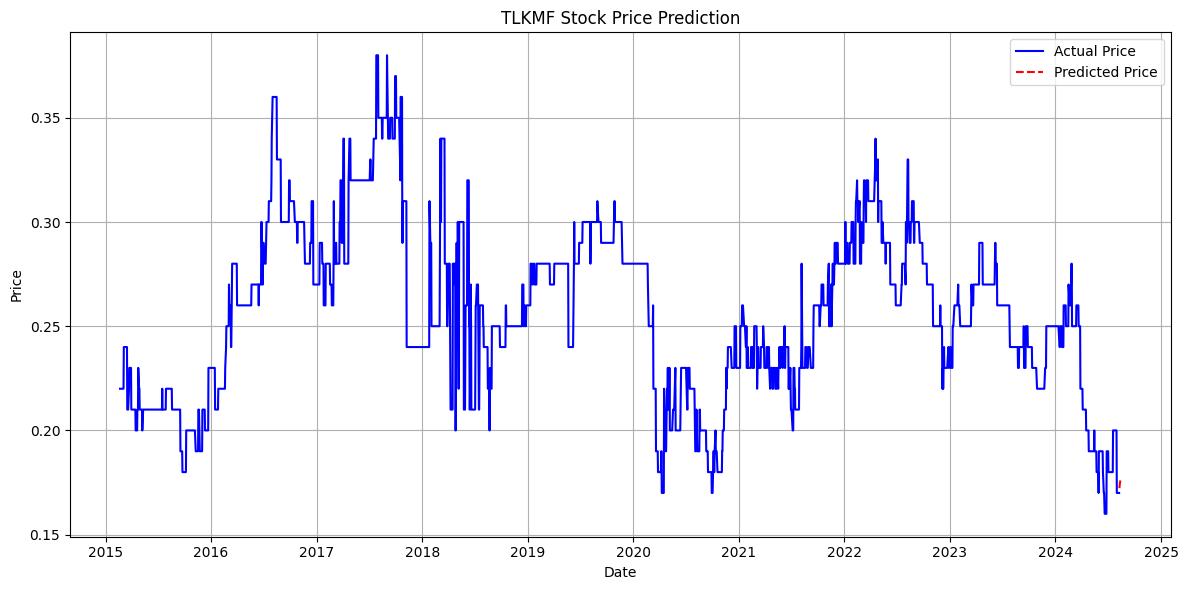

In [ ]:
# Plot the actual and predicted prices with dates
def plot_predictions(data, predicted_dates, predicted_prices):
    plt.figure(figsize=(12, 6))

    # Plot the actual prices
    plt.plot(data.index, data['Close'], label='Actual Price', color='blue')

    # Plot the predicted prices
    plt.plot(predicted_dates, predicted_prices, label='Predicted Price', color='red', linestyle='--')

    # Formatting the chart
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Call the function to plot the predictions
plot_predictions(data, predicted_dates, predicted_prices)


[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


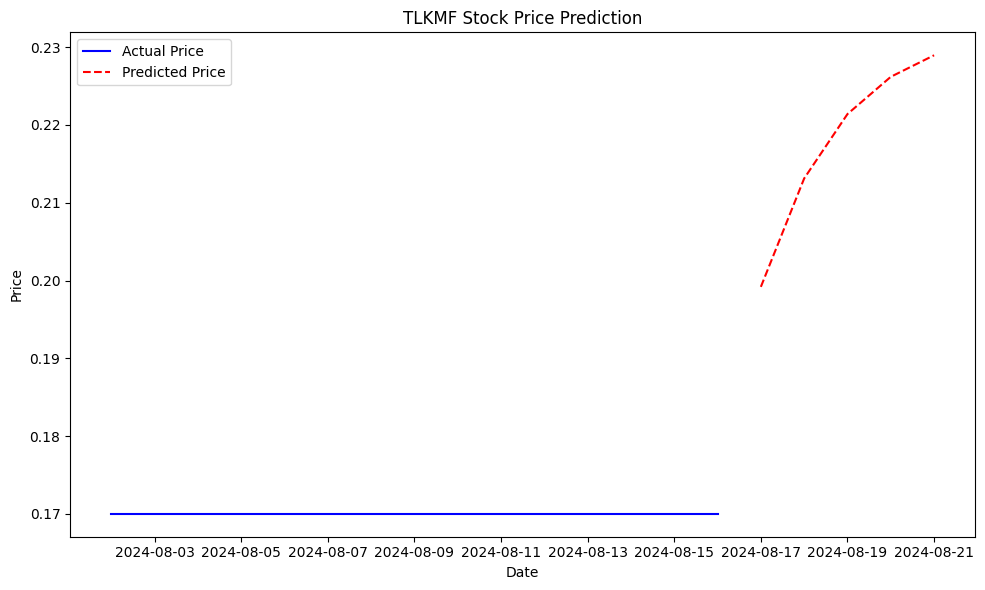

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import timedelta
import time

# Load the trained model
model = load_model('stock_price_prediction_model.h5', custom_objects={'mse': MeanSquaredError()})

# Function to fetch and prepare the latest data
def fetch_latest_data(ticker, seq_length):
    data = yf.download(ticker, period="1y", interval="1d")
    data['SMA_20'] = ta.trend.sma_indicator(data['Close'], window=20)
    data['EMA_20'] = ta.trend.ema_indicator(data['Close'], window=20)
    data['RSI'] = ta.momentum.rsi(data['Close'], window=14)
    data['MACD'] = ta.trend.macd_diff(data['Close'])
    data = data.dropna()

    # Only keep the columns that were used to fit the scaler
    data = data[['Close', 'SMA_20', 'EMA_20', 'RSI', 'MACD']]

    return data[-seq_length-10:]  # Last 10 days + the current day

# Function to predict the next `days` number of days
def predict_next_days(model, latest_data, scaler, seq_length, days=5):
    predicted_prices = []
    for _ in range(days):
        scaled_latest_data = scaler.transform(latest_data)
        X_latest = np.array([scaled_latest_data])
        predicted_price_scaled = model.predict(X_latest)
        predicted_price = scaler.inverse_transform(np.concatenate((predicted_price_scaled, np.zeros((1, 4))), axis=1))[:, 0][0]
        predicted_prices.append(predicted_price)
        new_data = np.concatenate(([[predicted_price]], latest_data.values[:, 1:]), axis=1)
        latest_data = pd.DataFrame(new_data, columns=latest_data.columns)
    return predicted_prices

# Real-time prediction and visualization loop
ticker = "TLKMF"
seq_length = 1
scaler = MinMaxScaler()

# Fetch the latest data (10 days of actual prices + current day)
latest_data = fetch_latest_data(ticker, seq_length)

# Scale the data
scaled_data = scaler.fit_transform(latest_data[['Close', 'SMA_20', 'EMA_20', 'RSI', 'MACD']])

# Predict the next 5 days
predicted_prices = predict_next_days(model, latest_data[-seq_length:], scaler, seq_length, days=5)

# Generate dates for the predicted prices
last_date = latest_data.index[-1]
predicted_dates = [last_date + timedelta(days=i + 1) for i in range(5)]

# Plot the actual prices (last 10 days) and predicted prices
plt.figure(figsize=(10, 6))
plt.plot(latest_data.index, latest_data['Close'], label='Actual Price', color='blue')
plt.plot(predicted_dates, predicted_prices, label='Predicted Price', color='red', linestyle='--')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Wait for the next interval (e.g., 1 day)
# time.sleep(86400)  # Sleep for 1 day (86400 seconds)
